## Customer Segmentation for Online Retail store

**Customer segmentation** is the process of dividing customers into groups based on common characteristics so companies can market to each group effectively and appropriately. We can perform segmentation using the data of which products users buy. 

The aim of this task is to find the various customer segments using the online retail store's transaction data obtained from [UCI Machine Learning Dataset repository](http://archive.ics.uci.edu/ml/datasets/online+retail). This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.


**Attributes Decsription:**

**InvoiceNo:** Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

**StockCode:** Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

**Description:** Product (item) name. Nominal.

**Quantity:** The quantities of each product (item) per transaction. Numeric.

**InvoiceDate:** Invice Date and time. Numeric, the day and time when each transaction was generated.

**UnitPrice:** Unit price. Numeric, Product price per unit in sterling.

**CustomerID:** Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

**Country:** Country name. Nominal, the name of the country where each customer resides.




### Load all required Dependencies

In [85]:
import pandas as pd
import numpy as np
import math
import warnings
import squarify
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

warnings.filterwarnings('ignore')

### Import Data

In [2]:
retail = pd.read_excel(io="Online Retail.xlsx")
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Exploratory Data Analysis

In [3]:
# get shape of our dataset
print("The shape of our dataset is: ", retail.shape)

The shape of our dataset is:  (541909, 8)


In [4]:
# check for missing values
np.sum(retail.isnull())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
#information about the rows and columns
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.8+ MB


It was observed that we have some missing values in the column CustomerID also the column Description. 

In [6]:
# Get more info about the quantitative parameters in the data (Quantity & UnitPrice)
retail[['Quantity','UnitPrice']].describe() 

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


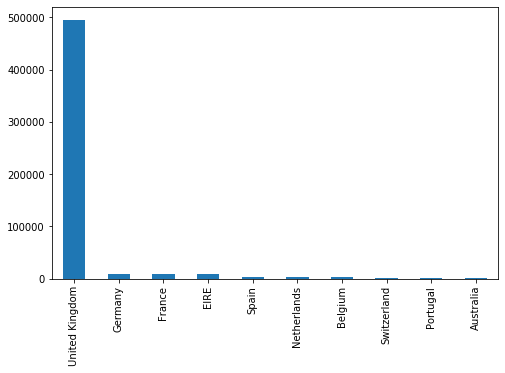

In [7]:
# Show list of countries where order comes from
retail.Country.value_counts().head(10).plot.bar(figsize=(8,5))

Since most of the orders come from UK, we will be using only the UK parametr in our data

In [8]:
#Create a copy of our dataframe
retail_copy = retail

In [9]:
# Drop duplicate rows
country_cus=retail_copy[['Country','CustomerID']].drop_duplicates()

# Country wise customer counts
country_cus.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False).head()

,Country,CustomerID
36,United Kingdom,3950
14,Germany,95
13,France,87
31,Spain,31
3,Belgium,25


In [10]:
# Drop duplicate rows
country_cus=retail_copy[['Country','CustomerID']].drop_duplicates()

In [11]:
# restrict the dataset to United Kingdom 
retail_uk = retail_copy.loc[retail_copy['Country'] == 'United Kingdom']

**Which are the most popular products in UK?**

In [57]:
uk_product = retail_uk.groupby(['StockCode','Description'],as_index= False)['Quantity'].sum().sort_values(by='Quantity', ascending=False)
uk_product.head(10)

,StockCode,Description,Quantity
2511,23843,"PAPER CRAFT , LITTLE BIRDIE",80995
2013,23166,MEDIUM CERAMIC TOP STORAGE JAR,76919
2687,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,49182
3545,85099B,JUMBO BAG RED RETROSPOT,41981
3552,85123A,WHITE HANGING HEART T-LIGHT HOLDER,34648
2792,84879,ASSORTED COLOUR BIRD ORNAMENT,32727
1031,22197,POPCORN HOLDER,28935
1426,22616,PACK OF 12 LONDON TISSUES,24337
37,17003,BROCADE RING PURSE,22711
356,21212,PACK OF 72 RETROSPOT CAKE CASES,22465


**Which are the least purchased products in UK?**

In [58]:
uk_product.tail(10)

,StockCode,Description,Quantity
1148,22323,PINK POLKADOT KIDS BAG,1
3703,90065B,BLACK VINT ART DEC CRYSTAL BRACELET,1
3779,90183C,BLACK DROP EARRINGS W LONG BEADS,1
983,22146,EASTER CRAFT IVY WREATH WITH CHICK,1
3777,90181A,AMBER GLASS/SHELL/PEARL NECKLACE,1
1050,22218,CAKE STAND LACE WHITE,1
87,20703,BLUE PADDED SOFT MOBILE,1
3774,90179C,BLACK FINE BEAD NECKLACE W TASSEL,1
3772,90178B,PURPLE CHUNKY GLASS+BEAD NECKLACE,1
2897,90021,LASER CUT MULTI STRAND NECKLACE,1


As mentioned in the description of the dataset, some codes in InvoiceNo start with the letter "c" = cancelled.
let's explore and confirm this.

In [12]:
#get cancelled transactions
cancelled = retail_copy[retail_copy['InvoiceNo'].astype(str).str.contains('C')]
cancelled.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [13]:
#search for transaction where quantity == -80995
cancelled[cancelled['Quantity']==-80995]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom


In [14]:
#chek if there is any positive quantity value in the cancelled orders
cancelled[cancelled['Quantity']>0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


Just as it was supposed to be, any Quantity with negative value means the order was cancelled

In [15]:
#now, we will check how many orders were cancelled
print("We have ",len(cancelled), " cancelled orders.")

#lets get the percentage of cancelled orders from the total orders
total_orders = retail_copy['InvoiceNo'].nunique()
cancelled_no = len(cancelled)
print('Percentage of cancelled orders: {}/{} ({:.2f}%) '.format(cancelled_no, total_orders, cancelled_no/total_orders*100))

We have  9288  cancelled orders.
Percentage of cancelled orders: 9288/25900 (35.86%) 


The percentage of cancelled orders of 35% is quite large. This will aid analysis of general customer behaviour and how to prevent future cancellation.

#### Explore Purchasing and Orders Trend

In [16]:
# unique InvoiceNo per customer
u_customers = pd.DataFrame(retail_copy.groupby('CustomerID')['InvoiceNo'].nunique())
u_customers.head()

,InvoiceNo
CustomerID,
12346.0,2
12347.0,7
12348.0,4
12349.0,1
12350.0,1


In [17]:
u_customers.describe()

,InvoiceNo
count,4372.000000
mean,5.075480
std,9.338754
min,1.000000
25%,1.000000
50%,3.000000
75%,5.000000
max,248.000000


The average number of orders per customer is 5.
Now, let's examine how many products are purchased and also check if those orders are from the same product.

In [18]:
#What's the average number of unique items per order? 
u_invoice = pd.DataFrame(retail_copy.groupby('InvoiceNo')['StockCode'].nunique())
u_invoice.columns=['productsNumber']
u_invoice.head()

,productsNumber
InvoiceNo,
536365,7
536366,2
536367,12
536368,4
536369,1


In [19]:
u_invoice.describe()

,productsNumber
count,25900.000000
mean,20.510618
std,42.500488
min,1.000000
25%,2.000000
50%,10.000000
75%,23.000000
max,1110.000000


In [21]:
# number of products per customer and unique orders
comp =retail_copy.groupby(['InvoiceNo','CustomerID'],as_index=False)['InvoiceDate'].count()
transactions = comp.rename(columns = {'InvoiceDate':'Number of products'})
transactions.head()

,InvoiceNo,CustomerID,Number of products
0,536365,17850.0,7
1,536366,17850.0,2
2,536367,13047.0,12
3,536368,13047.0,4
4,536369,13047.0,1


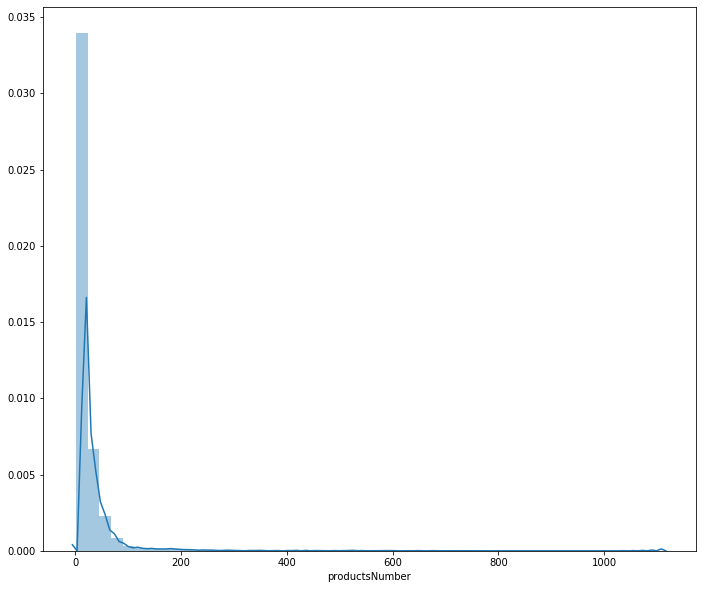

In [24]:
#lets get a Visualization for more insights on the products distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 10)
sns.distplot(u_invoice['productsNumber'],ax=ax)
plt.show()

In [25]:
# What are the most ourchased products?

u_Product = retail_copy.groupby('StockCode',as_index= False)['Quantity'].sum().sort_values(by='Quantity', ascending=False)
u_Product.head(10)
#check how to show product description instead of StockCode

,StockCode,Quantity
1070,22197,56450
2622,84077,53847
3659,85099B,47363
3670,85123A,38830
2735,84879,36221
377,21212,36039
1905,23084,30646
1335,22492,26437
1453,22616,26315
889,21977,24753


In [26]:
invoice_quantity= retail_copy.groupby('InvoiceNo', as_index=False)['Quantity'].sum().sort_values(by='Quantity', ascending=False)
invoice_quantity.head()

,InvoiceNo,Quantity
22025,581483,80995
2303,541431,74215
9951,556917,15049
12983,563076,14730
18776,574941,14149


We need to explore more about the most purchased products. We will do **"Market Basket Analysis"** which will help us to find out if there is any product if when bought influecies the purchase of another product.

### Market Basket Analysis

In [32]:
#Create a copy of our dataframe for MBA
retail_mba = retail

**Data wrangling for MBA**

In [33]:
#remove additional spaces
retail_mba['Description'] = retail_mba['Description'].str.strip()
#remove null values
retail_mba.dropna(axis=0, subset=['InvoiceNo'], inplace=True)
#remove cancelled orders
retail_mba['InvoiceNo'] = retail_mba['InvoiceNo'].astype('str')
retail_mba = retail_mba[~retail_mba['InvoiceNo'].str.contains('C')]

In [34]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

def create_basket(country_filter):
    basket = (retail_copy[retail_copy['Country'] == country_filter]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))
    return basket

In [35]:
# create a country filter basket
country_filter = "France"
basket_fr = create_basket("France")
basket_sets = basket_fr.applymap(encode_units)
basket_sets.drop('POSTAGE', inplace=True, axis=1)

In [28]:
# import needed dependencies for mba
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [36]:
frequent_itemsets = apriori(basket_sets, min_support=0.05, use_colnames=True)

In [37]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.096939,0.102041,0.073980,0.763158,7.478947,0.064088,3.791383
1,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.102041,0.096939,0.073980,0.725000,7.478947,0.064088,3.283859
2,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.094388,0.096939,0.079082,0.837838,8.642959,0.069932,5.568878
3,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.096939,0.094388,0.079082,0.815789,8.642959,0.069932,4.916181
4,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE PINK),0.094388,0.102041,0.073980,0.783784,7.681081,0.064348,4.153061


From the results, a customer is 7 times more likely to buy a "ALARM CLOCK BAKELIKE(PINK)" than an average customer (from the lift) if she buys "ALARM CLOCK BAKELIKE (GREEN)". This is backed up by 76% of confidence. This phenomenol can aid in recommedation sytems for the products where the pink alarm clock is recommeded when a customer buys the green one. 

In [38]:
basket_germany = create_basket("Germany")
basket2_sets = basket_germany.applymap(encode_units)
basket2_sets.drop('POSTAGE', inplace=True, axis=1)

In [39]:
frequent_itemsets_germany = apriori(basket2_sets, min_support=0.05, use_colnames=True)

In [40]:
rules = association_rules(frequent_itemsets_germany, metric="lift", min_threshold=1.2)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PLASTERS IN TIN CIRCUS PARADE),(PLASTERS IN TIN WOODLAND ANIMALS),0.115974,0.137856,0.067834,0.584906,4.242887,0.051846,2.076984
1,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN CIRCUS PARADE),0.137856,0.115974,0.067834,0.492063,4.242887,0.051846,1.740427
2,(ROUND SNACK BOXES SET OF 4 FRUITS),(PLASTERS IN TIN CIRCUS PARADE),0.157549,0.115974,0.050328,0.319444,2.754455,0.032057,1.298977
3,(PLASTERS IN TIN CIRCUS PARADE),(ROUND SNACK BOXES SET OF 4 FRUITS),0.115974,0.157549,0.050328,0.433962,2.754455,0.032057,1.488330
4,(PLASTERS IN TIN CIRCUS PARADE),(ROUND SNACK BOXES SET OF4 WOODLAND),0.115974,0.245077,0.056893,0.490566,2.001685,0.028470,1.481887


From the results, a customer is 4 times more likely to buy a "PLASTERS IN TIN WOODLAND ANIMALS" than an average customer (from the lift) if she buys "PLASTERS IN TIN CIRCUS PARADE". This is backed up by 49% of confidence. This phenomenol can aid in recommedation sytems for the products where the PLASTERS IN TIN WOODLAND ANIMALS is recommeded when a customer buys the PLASTERS IN TIN CIRCUS PARADE.

**Perspective:**
It is recommeded to look at how much opportunity there is to use the popularity of one product to drive sales to another by applying "Collaborative Filtering Recommendations" based on purchased items and those influenced by the purchased of another.
.




## Recency-Frequency-Monetary (RFM)

RFM (Recency, Frequency, Monetary) analysis is a customer segmentation technique that uses past purchase behavior to divide customers into groups.

We will be employing thr RFM Analysis fur our customers segmentation based on buying behavior. We will determine the historical actions of individual customers for each RFM factor.Then, we will rank customers based on each individual RFM factor, and finally pull all the factors together to create RFM segments for targeted marketing.

For this Online Retail Customer Segmentation, RFM will help us answer the following:

* RECENCY (R): Shows the timeline between purchases from a customer
* FREQUENCY (F): Shows the total number of purchases from a customer
* MONETARY VALUE (M): Shows the total money a customer spent. 

In [45]:
#Create a copy of our dataframe for the rfm analysis
retail_rfm = retail

In [47]:
retail_rfm.head()                       

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


**Data Wrangling for RFM**

In [49]:
# summary statistics
retail_rfm[['Quantity','UnitPrice']].describe()   

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [50]:
# Drop duplicate rows
customer_country=retail_rfm[['Country','CustomerID']].drop_duplicates()

# customers per country
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False).head()

,Country,CustomerID
36,United Kingdom,3950
14,Germany,95
13,France,87
31,Spain,31
3,Belgium,25


Since more than 90% of the customers are from the United Kingdom, we will restrict the data to United Kingdom to focused on the geography varied cluster.

In [51]:
# restrict data to the United Kingdom 
retail_uk = retail_rfm.loc[retail_rfm['Country'] == 'United Kingdom']

In [52]:
#check for missing values
retail_uk = retail_uk[pd.notnull(retail_uk['CustomerID'])]
retail_uk.isnull().sum(axis=0)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [53]:
## check the percentage of negatuve values in Quantity column 
len(retail_uk[retail_uk.Quantity<0])*100/len(retail_uk)

2.0816407739624956

Since about 2% of the values in Quantity are negative, we will be using the values that are positive

In [54]:
# read only values that are positive
retail_uk = retail_uk[(retail_uk['Quantity']>0)]
retail_uk.Quantity.min()

1

In [55]:
retail_uk.shape

(354345, 8)

In [88]:
#Convert Invoice date to datetime
retail_uk['InvoiceDate'] = pd.to_datetime(retail_uk['InvoiceDate'])

In [92]:
from datetime import date
now = dt.date(2011,12,9)
print(now)

2011-12-09


In [94]:
#create a new column called date which contains the date of invoice only
retail_uk['date'] = retail_uk['InvoiceDate'].dt.date
retail_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01


In [95]:
#group by customers and check last date of purchase
recency_df = retail_uk.groupby(by='CustomerID', as_index=False)['date'].max()
recency_df.columns = ['CustomerID','LastPurchaseDate']
recency_df.head()

,CustomerID,LastPurchaseDate
0,12346.0,2011-01-18
1,12747.0,2011-12-07
2,12748.0,2011-12-09
3,12749.0,2011-12-06
4,12820.0,2011-12-06


**Recency**

In [96]:
#calculate recency
recency_df['Recency'] = recency_df['LastPurchaseDate'].apply(lambda x: (now - x).days)

In [97]:
recency_df.head()

,CustomerID,LastPurchaseDate,Recency
0,12346.0,2011-01-18,325
1,12747.0,2011-12-07,2
2,12748.0,2011-12-09,0
3,12749.0,2011-12-06,3
4,12820.0,2011-12-06,3


**Frequency**

In [99]:
# drop duplicates
retail_uk_copy = retail_uk
retail_uk_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)

In [100]:
#calculate frequency of purchases
frequency_df = retail_uk_copy.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,11
2,12748.0,210
3,12749.0,5
4,12820.0,4


**Monetary Value**

In [101]:
#create column or total cost price per invoice
retail_uk['TotalCost'] = retail_uk['Quantity'] * retail_uk['UnitPrice']
monetary_df = retail_uk.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12747.0,689.49
2,12748.0,3841.31
3,12749.0,98.35
4,12820.0,58.20


**Create RFM Table**

In [102]:
#merge recency dataframe with frequency dataframe
rf_df = recency_df.merge(frequency_df,on='CustomerID')
rf_df.head()

,CustomerID,LastPurchaseDate,Recency,Frequency
0,12346.0,2011-01-18,325,1
1,12747.0,2011-12-07,2,11
2,12748.0,2011-12-09,0,210
3,12749.0,2011-12-06,3,5
4,12820.0,2011-12-06,3,4


In [103]:
#merge with monetary dataframe to get a table with the 3 rfm parameters columns
rfm_table = rf_df.merge(monetary_df,on='CustomerID')

In [106]:
#drop LastPurchaseDate as we don't need it anymore
rfm_table.drop('LastPurchaseDate',axis=1,inplace=True)

In [108]:
#use CustomerID as index
rfm_table.set_index('CustomerID',inplace=True)

#check the head
rfm_table.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,11,689.49
12748.0,0,210,3841.31
12749.0,3,5,98.35
12820.0,3,4,58.20


Insight:

CustomerID 12346 has Frequency: 1, Monetary value: $77183.60 and Recency: 325 days.

CustomerID 12747 has Frequency: 11, Monetary value: $689.49 and Recency: 2 days.

Let's verify RFM table correctness using the details of the first customer.

**Verify RFM Table Correctness**

In [109]:
retail_uk[retail_uk['CustomerID']==12346.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,date,TotalCost
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.6,2011-01-18,77183.6


**Insight:** 
As we can see our RFM table is correct. The first customer has purchased only once, and only one product at a huge quantity(74215). 


The simplest way to create customers segments from RFM Model is to use Quartiles. This will give us a starting point for detailed analysis. Also a 4 segments are easy to understand and explain.

**RFM Quartiles**

In [124]:
quantiles = rfm_table.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary,R_Quartile,F_Quartile
0.25,17.0,1.0,17.7,1.0,4.0
0.50,50.0,2.0,45.4,1.0,4.0
0.75,142.0,5.0,124.5,1.0,4.0


In [125]:
#Convert quantiles to dictionary
quantiles = quantiles.to_dict()
quantiles

{'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 142.0},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'Monetary': {0.25: 17.700000000000003, 0.5: 45.4, 0.75: 124.50000000000001},
 'R_Quartile': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'F_Quartile': {0.25: 4.0, 0.5: 4.0, 0.75: 4.0}}

In [119]:
# Create functions to separate customers into segments such as 1,2,3,4 based on quantile allocation.

# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [127]:
#create rfm segmentation table
rfm_segmentation = rfm_table
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
#rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary_value'].apply(FMScore, args=('Monetary_value',quantiles,))

In [128]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile
CustomerID,,,,,
12346.0,325,1,77183.60,4,4
12747.0,2,11,689.49,1,1
12748.0,0,210,3841.31,1,1
12749.0,3,5,98.35,1,2
12820.0,3,4,58.20,1,2


In [130]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            #+ rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,RFMScore
CustomerID,,,,,,
12346.0,325,1,77183.60,4,4,44
12747.0,2,11,689.49,1,1,11
12748.0,0,210,3841.31,1,1,11
12749.0,3,5,98.35,1,2,12
12820.0,3,4,58.20,1,2,12


**Check how many customers are under each segments**

In [132]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='44']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
#print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='24']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='14']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='11']))

Best Customers:  645
Loyal Customers:  1351
Almost Lost:  239
Lost Customers:  89
Lost Cheap Customers:  479


In [135]:
rfm_data = rfm_table.drop(['R_Quartile','F_Quartile','RFMScore'],axis=1)
rfm_data.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,11,689.49
12748.0,0,210,3841.31
12749.0,3,5,98.35
12820.0,3,4,58.20


In [136]:
rfm_data.corr()

,Recency,Frequency,Monetary
Recency,1.000000,-0.273779,-0.030123
Frequency,-0.273779,1.000000,0.163225
Monetary,-0.030123,0.163225,1.000000


**Data visualization**

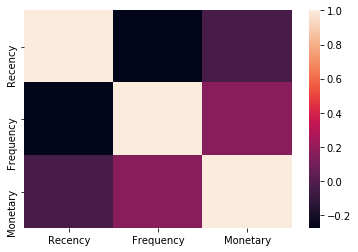

In [137]:
sns.heatmap(rfm_data.corr())

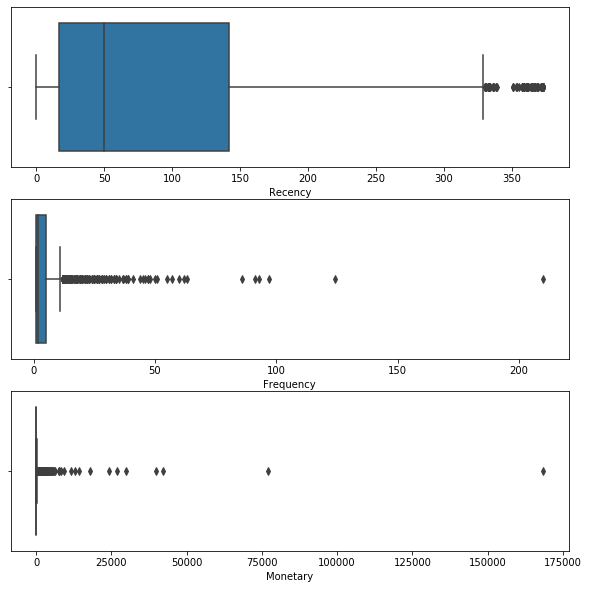

In [141]:
# a Plot pf recency, freqiency and monetary value distribution
fig,ax=plt.subplots(3,1)
fig.set_size_inches(w=10,h=10)
sns.boxplot(x='Recency',data=rfm_data,ax=fig.axes[0])
sns.boxplot(x='Frequency',data=rfm_data,ax=fig.axes[1])
sns.boxplot(x='Monetary',data=rfm_data,ax=fig.axes[2])

**Insight:**
Frequency and monetary value are positively correlated with each other implying an increase in frequency implies increase in monetary value.

Frequency and Recency are negatively correlated with each other implying an increase in frequency implies decrease in monetary value.

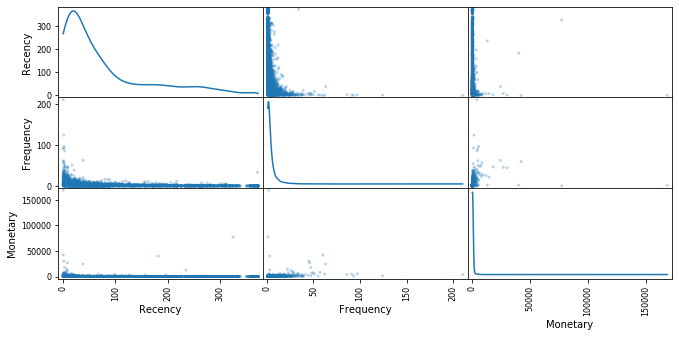

In [143]:
# create a scatter matrix for each pair of features in the rfm data
from pandas.plotting import scatter_matrix

scatter_matrix(rfm_data, alpha = 0.3, figsize = (11,5), diagonal = 'kde');

We observed that we have a skewed distribution of the 3 variables and outliers also exis.

This means we need to employ normalization to make the data features normally distributed as clustering algorithms required. 

**Normalization**

In [144]:
#log transformation
rfm_r_log = np.log(rfm_data['Recency']+0.1) # itcan't take log(0) and so we add a tiny integer
rfm_f_log = np.log(rfm_data['Frequency'])
rfm_m_log = np.log(rfm_data['Monetary']+0.1)

In [145]:
log_data = pd.DataFrame({'Monetary': rfm_m_log,'Recency': rfm_r_log,'Frequency': rfm_f_log})

In [146]:
log_data.head()

,Monetary,Recency,Frequency
CustomerID,,,
12346.0,11.253944,5.784133,0.000000
12747.0,6.536097,0.741937,2.397895
12748.0,8.253595,-2.302585,5.347108
12749.0,4.589549,1.131402,1.609438
12820.0,4.065602,1.131402,1.386294


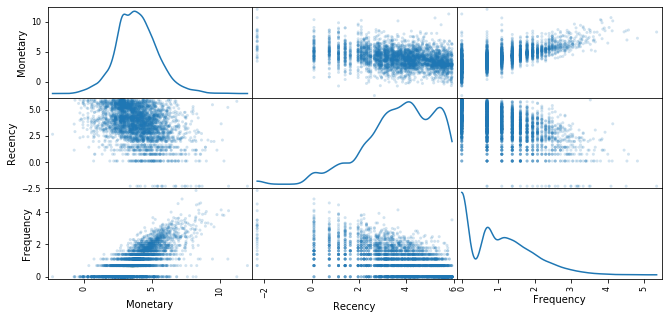

In [147]:
# create another scatter matrix 
scatter_matrix(log_data, alpha = 0.2, figsize = (11,5), diagonal = 'kde');

In [148]:
log_data.corr()

,Monetary,Recency,Frequency
Monetary,1.000000,-0.368472,0.716935
Recency,-0.368472,1.000000,-0.573982
Frequency,0.716935,-0.573982,1.000000


Monetary and Frequency are more strongly correlated.

**Perspective:**
To gain further insight into customer behavior, we can dig deeper in the relationship between RFM variables.

RFM model can be used in conjunction with predictive models like K-means clustering to produce better informative results on customer behavior.

### Applying K-means clustering on RFM variables

In [149]:
# Initialize KMeans
kmeans = KMeans(n_clusters=4,init='k-means++', max_iter=300, n_init=10, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(log_data)

# Extract cluster labels
cluster_labels = kmeans.labels_

In [150]:
#Create a DataFrame by adding a new cluster label column
km = log_data.assign(Cluster=cluster_labels)

# Group the data by cluster
grouped = km.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
  }).round(1)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0           2.7       0.9      3.4   868
1           1.6       2.3      5.9   643
2           4.9       0.2      2.5  1273
3           4.4       1.1      4.7  1137

In [151]:
# Melt the normalized dataset and reset the index
km_melt = pd.melt(km.reset_index(), 
                        
# Assign CustomerID and Cluster as ID variables                  
                    id_vars=['CustomerID', 'Cluster'],

# Assign RFM values as value variables
                    value_vars=['Recency', 'Frequency', 'Monetary'], 
                        
# Name the variable and value
                    var_name='Metric', value_name='Value')

In [152]:
km_melt.head()

,CustomerID,Cluster,Metric,Value
0,12346.0,3,Recency,5.784133
1,12747.0,1,Recency,0.741937
2,12748.0,1,Recency,-2.302585
3,12749.0,1,Recency,1.131402
4,12820.0,0,Recency,1.131402
